In [ ]:
# default_exp model

# Training the model

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
from fastai.vision.all import *
from mangacover.datasets.loaders import get_mangacover_dataloaders
import pandas as pd

# create_multiclass_tag_manga_dataset('data/')
dls = get_mangacover_dataloaders('data/')
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.9))

We use the LR finder to figure the best learning rate first

/opt/conda/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


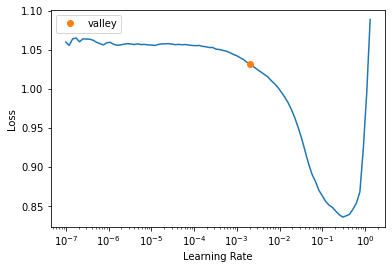

In [ ]:
lr = learn.lr_find()

In [ ]:
lr.valley

tensor(0.0021)

There's still some understanding that I personally lack about the finder and the new algorithms it has, but it looks like 
using valley is indicated so for now we'll proceed with this one.

In [ ]:
learn.fine_tune(8, base_lr=0.0021, freeze_epochs=6)

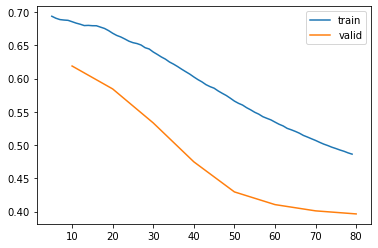

In [ ]:
learn.recorder.plot_loss()

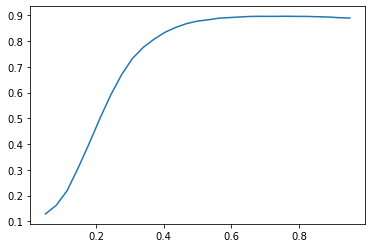

In [ ]:
preds,targs = learn.get_preds()
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs)

In [ ]:
learn.export('models/multiclass.pkl')

# Loading the model and getting predictions

In [ ]:
# export
import json

def load_learner_and_predict(path, image_data, thresh=0.5):
    """Load the learner from `path` and predicts the labels for `image`.
    
    Returns a JSON string, ideal for http requests."""
    learner = load_learner(path)
    image = PILImage.create(image_data)
    _, _, probs = learner.predict(image)
    preds = list(zip(learner.dls.vocab, [prob.item() for prob in probs]))
    preds = [(lab, prob) for lab, prob in preds if prob >= thresh]
    preds.sort(key=lambda x: x[1], reverse=True)
    return json.dumps(
        {
            "preds": [
                {
                    "label": label,
                    "probability": prob,
                }
                for label, prob in preds
            ]
        }
    )

In [ ]:
show_doc(load_learner_and_predict)

<h4 id="load_learner_and_predict" class="doc_header"><code>load_learner_and_predict</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>load_learner_and_predict</code>(**`path`**, **`image`**, **`thresh`**=*`0.5`*)

Load the learner from `path` and predicts the labels for `image`.

Returns a JSON string, ideal for http requests.

In [ ]:
from fastai.vision.widgets import *

In [ ]:
img = PILImage.create('data/test/test.jpg')

In [ ]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [ ]:
load_learner_and_predict('models/multiclass.pkl', 'data/test/test.jpg', thresh=0.7)

'{"preds": [{"label": "Adventure", "probability": 0.8760659098625183}]}'